In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import networkx as nx

In [2]:
from ema_workbench import (Model, MultiprocessingEvaluator, RealParameter,  CategoricalParameter, IntegerParameter, RealParameter, ScalarOutcome, TimeSeriesOutcome, Policy, Scenario, ema_logging, Constant)

from ema_workbench.em_framework.evaluators import perform_experiments, Samplers, LHSSampler, SobolSampler,MorrisSampler
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import feature_scoring, parcoords
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from problem_formulation import get_model_for_problem_formulation

import time

from SALib.analyze import sobol

In [3]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.2.4
2.5


In [4]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [6]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
#enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))
    
levers = dike_model.levers 

import copy
levers = copy.deepcopy(dike_model.levers)

In [8]:
#enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'), function=<function sum_over at 0x000001BA24D05310>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'), function=<function sum_over at 0x000001BA24D05310>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'), function=<function sum_over at 0x000001BA24D05310>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2'), function=<function sum_over at 0

In [9]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=50, policies=4)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 50 scenarios * 4 policies * 1 model(s) = 200 experiments
100%|████████████████████████████████████████| 200/200 [00:41<00:00,  4.81it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
#observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())
experiments

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,101,149.922473,1.0,0.842554,295.109884,1.0,0.236128,298.506421,10,0.434060,...,9,1,0,6,5,10,4,4,0,dikesnet
1,97,281.862922,1.5,0.299070,81.742066,1.5,0.307058,319.157170,10,0.954021,...,9,1,0,6,5,10,4,5,0,dikesnet
2,131,158.759947,1.5,0.158363,178.765439,1.5,0.770598,340.157862,1.5,0.612692,...,9,1,0,6,5,10,4,6,0,dikesnet
3,58,189.871495,1.5,0.134502,150.224488,1.5,0.397133,89.650095,1.5,0.209806,...,9,1,0,6,5,10,4,7,0,dikesnet
4,87,208.006378,1.0,0.592066,72.254613,1.5,0.146896,183.176620,1.5,0.354089,...,9,1,0,6,5,10,4,8,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,21,129.431949,1.0,0.107441,195.740914,1.0,0.639080,166.422054,10,0.836897,...,0,10,5,2,10,7,0,49,3,dikesnet
196,114,248.418481,1.5,0.214913,211.400924,10,0.066042,213.698416,1.0,0.143902,...,0,10,5,2,10,7,0,50,3,dikesnet
197,113,52.155326,10,0.442240,299.974841,10,0.972636,249.589063,1.5,0.786421,...,0,10,5,2,10,7,0,51,3,dikesnet
198,39,83.509598,10,0.743860,63.835613,1.5,0.356191,192.503705,10,0.467352,...,0,10,5,2,10,7,0,52,3,dikesnet


In [11]:
outcomes['A.1 Total Costs'].shape
problem = get_SALib_problem(uncertainties)
print(problem)


{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [12]:
#SOBOL SENSITIVITY ANALYSIS
#to see how much the uncertainties add to the variance of the outcomes

with MultiprocessingEvaluator(dike_model) as evaluator:
    sobol_results = evaluator.perform_experiments(scenarios=50, policies=4, uncertainty_sampling=Samplers.SOBOL)
experiments_sobol, outcomes_sobol = sobol_results

[MainProcess/INFO] pool started with 16 workers
C:\Users\annoe\anaconda3\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (50) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 2000 scenarios * 4 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [34:59<00:00,  3.81it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


A.1 Total Costs
                               ST   ST_conf        S1   S1_conf
A.0_ID flood wave shape  0.002764  0.004402 -0.001586  0.006260
A.1_Bmax                 0.000000  0.000000  0.000000  0.000000
A.1_Brate                0.000000  0.000000  0.000000  0.000000
A.1_pfail                0.834018  0.337761  0.769734  0.514113
A.2_Bmax                 0.000000  0.000000  0.000000  0.000000
A.2_Brate                0.000000  0.000000  0.000000  0.000000
A.2_pfail                0.000000  0.000000  0.000000  0.000000
A.3_Bmax                 0.000000  0.000000  0.000000  0.000000
A.3_Brate                0.000000  0.000000  0.000000  0.000000
A.3_pfail                0.000000  0.000000  0.000000  0.000000
A.4_Bmax                 0.000000  0.000000  0.000000  0.000000
A.4_Brate                0.000000  0.000000  0.000000  0.000000
A.4_pfail                0.000000  0.000000  0.000000  0.000000
A.5_Bmax                 0.000000  0.000000  0.000000  0.000000
A.5_Brate               

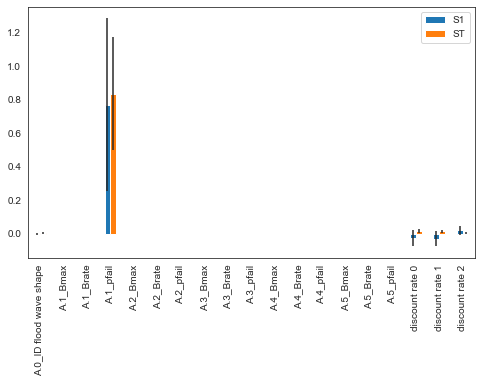

A.1_Expected Number of Deaths
                               ST   ST_conf        S1   S1_conf
A.0_ID flood wave shape  0.001901  0.002338 -0.002823  0.003334
A.1_Bmax                 0.000000  0.000000  0.000000  0.000000
A.1_Brate                0.000000  0.000000  0.000000  0.000000
A.1_pfail                0.770284  0.262565  0.813433  0.496220
A.2_Bmax                 0.000000  0.000000  0.000000  0.000000
A.2_Brate                0.000000  0.000000  0.000000  0.000000
A.2_pfail                0.000000  0.000000  0.000000  0.000000
A.3_Bmax                 0.000000  0.000000  0.000000  0.000000
A.3_Brate                0.000000  0.000000  0.000000  0.000000
A.3_pfail                0.000000  0.000000  0.000000  0.000000
A.4_Bmax                 0.000000  0.000000  0.000000  0.000000
A.4_Brate                0.000000  0.000000  0.000000  0.000000
A.4_pfail                0.000000  0.000000  0.000000  0.000000
A.5_Bmax                 0.000000  0.000000  0.000000  0.000000
A.5_Brate 

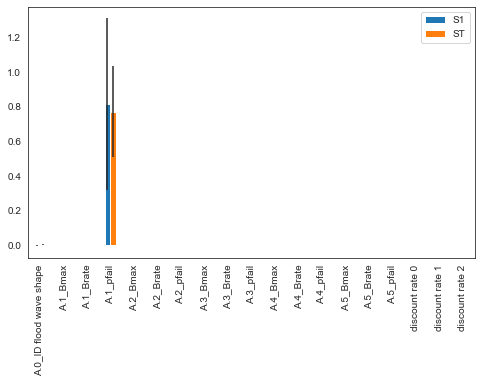

A.2 Total Costs
                                   ST       ST_conf            S1  \
A.0_ID flood wave shape  8.464597e-04  8.006782e-04  4.166430e-03   
A.1_Bmax                 5.836609e-06  1.147472e-05  3.235106e-04   
A.1_Brate                1.389195e-15  2.731144e-15  4.991026e-09   
A.1_pfail                2.660783e-04  4.406104e-04  7.810980e-04   
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.2_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.2_pfail                1.005817e-01  6.078212e-02  9.844630e-02   
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.3_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.3_pfail                0.000000e+00  0.000000e+00  0.000000e+00   
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.4_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.4_pfail                0.000000e+00  0.000000e+00  0.000000e+00   
A.5_Bmax          

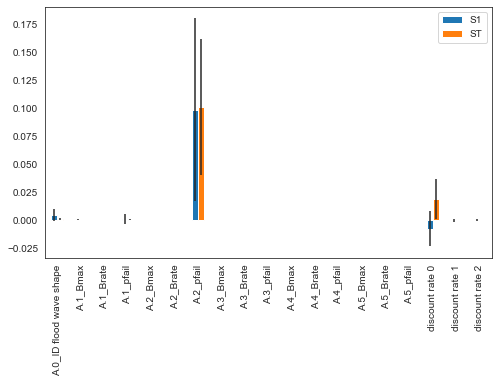

A.2_Expected Number of Deaths
                                   ST       ST_conf            S1  \
A.0_ID flood wave shape  4.263654e-03  5.223018e-03 -1.298798e-03   
A.1_Bmax                 1.246783e-05  3.447474e-05  7.076693e-05   
A.1_Brate                1.183563e-14  3.272667e-14  2.180373e-09   
A.1_pfail                1.413287e-03  2.820441e-03  6.431294e-04   
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.2_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.2_pfail                6.061033e-01  3.425238e-01  5.668362e-01   
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.3_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.3_pfail                0.000000e+00  0.000000e+00  0.000000e+00   
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.4_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.4_pfail                0.000000e+00  0.000000e+00  0.000000e+00   
A.5_

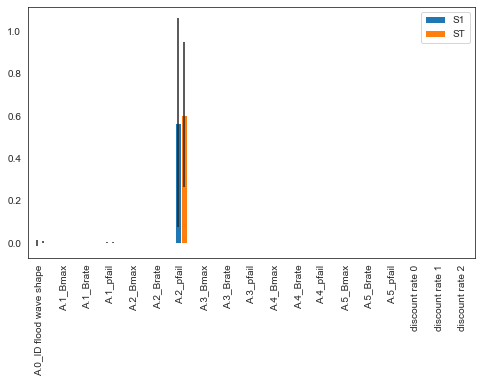

A.3 Total Costs
                                   ST       ST_conf        S1   S1_conf
A.0_ID flood wave shape  9.839490e-04  1.480583e-03 -0.007608  0.009230
A.1_Bmax                 2.748728e-05  6.592160e-05  0.000399  0.000951
A.1_Brate                4.771802e-09  1.604527e-08  0.000003  0.000004
A.1_pfail                4.974829e-03  1.027301e-02 -0.001527  0.015981
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_pfail                1.144401e-04  2.698813e-04 -0.000318  0.001861
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.3_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.3_pfail                1.111723e+00  3.152131e-01  0.778163  0.863798
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_pfail                0.000000e+00  0.000000e

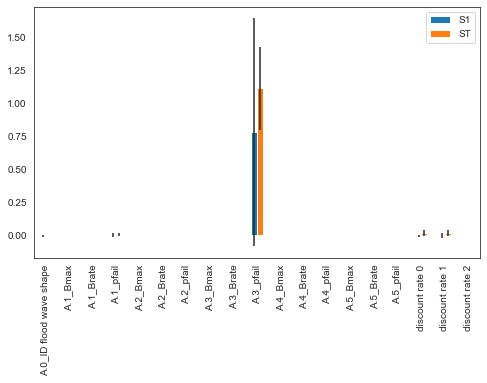

A.3_Expected Number of Deaths
                                   ST       ST_conf        S1   S1_conf
A.0_ID flood wave shape  1.636111e-03  2.469830e-03 -0.008875  0.010550
A.1_Bmax                 1.092845e-05  3.001812e-05  0.000058  0.000168
A.1_Brate                6.870637e-09  1.912788e-08  0.000005  0.000008
A.1_pfail                3.174218e-03  7.481354e-03  0.000204  0.003392
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_pfail                1.104123e-04  3.042030e-04 -0.000065  0.000414
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.3_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.3_pfail                1.097600e+00  2.488258e-01  0.820074  0.945507
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_pfail                0.000000e

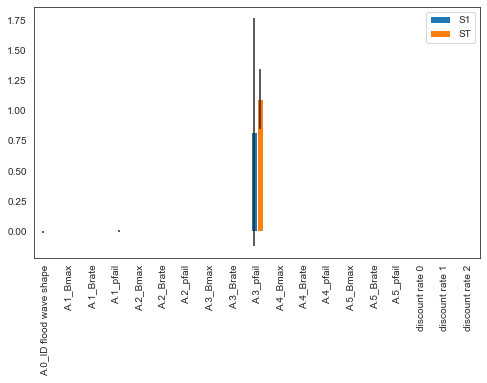

A.4 Total Costs
                                   ST       ST_conf            S1   S1_conf
A.0_ID flood wave shape  1.084302e-03  1.203195e-03 -7.635098e-03  0.010523
A.1_Bmax                 2.410659e-05  4.785568e-05  1.170662e-04  0.000232
A.1_Brate                1.025097e-09  2.034992e-09  7.633895e-07  0.000002
A.1_pfail                2.248208e-04  4.038046e-04 -3.589508e-04  0.000733
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.2_Brate                0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.2_pfail                9.361746e-07  1.702936e-06  2.306971e-05  0.000042
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.3_Brate                0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.3_pfail                1.847987e-04  2.106534e-04 -7.692507e-05  0.001648
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000000e+00  0.000

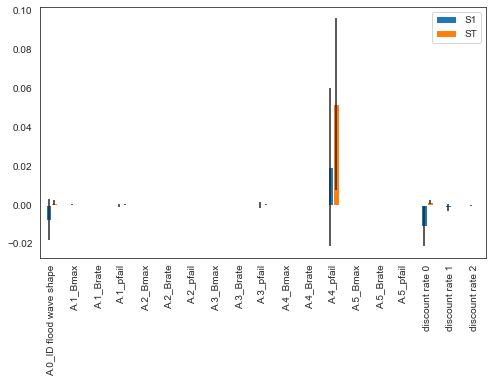

A.4_Expected Number of Deaths
                                   ST       ST_conf            S1   S1_conf
A.0_ID flood wave shape  3.484347e-02  3.505259e-02 -1.188043e-02  0.044320
A.1_Bmax                 1.629730e-05  3.900746e-05  8.310139e-05  0.000199
A.1_Brate                1.031777e-09  2.469550e-09  6.612161e-07  0.000002
A.1_pfail                2.128174e-04  5.688664e-04 -3.132093e-04  0.000889
A.2_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.2_Brate                0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.2_pfail                3.016422e-07  1.158079e-06  1.130567e-05  0.000043
A.3_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.3_Brate                0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.3_pfail                1.530507e-03  3.187559e-03  5.385350e-04  0.002248
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000

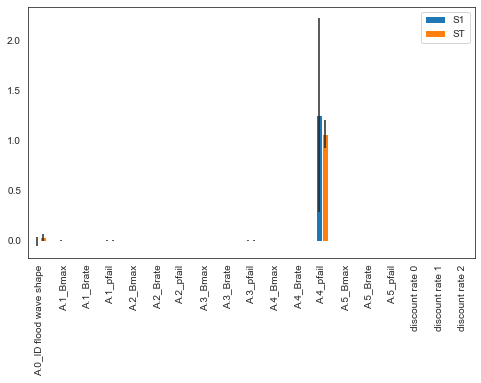

A.5 Total Costs
                                   ST       ST_conf        S1   S1_conf
A.0_ID flood wave shape  1.301897e-02  9.818219e-03  0.042079  0.054825
A.1_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.1_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.1_pfail                0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_Bmax                 8.556598e-04  1.488837e-03  0.001953  0.006411
A.2_Brate                1.596251e-06  1.924087e-06  0.000071  0.000262
A.2_pfail                1.466012e-02  1.455529e-02  0.008462  0.032601
A.3_Bmax                 1.778054e-08  3.615718e-08 -0.000008  0.000022
A.3_Brate                3.148359e-09  6.856991e-09 -0.000004  0.000010
A.3_pfail                1.021357e-02  2.223325e-02  0.008291  0.020062
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_pfail                2.817586e-03  4.803856e

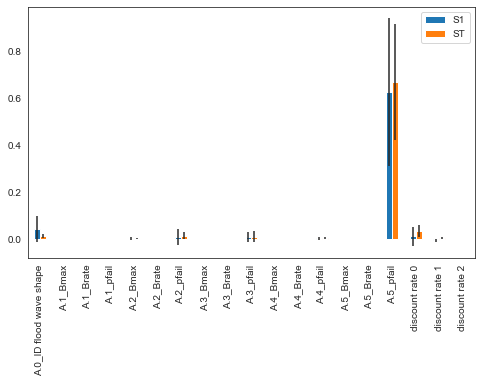

A.5_Expected Number of Deaths
                                   ST       ST_conf        S1   S1_conf
A.0_ID flood wave shape  1.672341e-02  1.922890e-02  0.029536  0.044787
A.1_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.1_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.1_pfail                0.000000e+00  0.000000e+00  0.000000  0.000000
A.2_Bmax                 2.446188e-04  3.571258e-04 -0.000087  0.001159
A.2_Brate                5.811205e-07  1.299461e-06  0.000012  0.000062
A.2_pfail                9.930861e-03  1.598281e-02  0.007474  0.024131
A.3_Bmax                 7.438806e-08  1.929225e-07 -0.000007  0.000020
A.3_Brate                6.352640e-09  1.750022e-08 -0.000002  0.000006
A.3_pfail                1.207613e-02  1.935220e-02 -0.000138  0.012649
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_Brate                0.000000e+00  0.000000e+00  0.000000  0.000000
A.4_pfail                8.171407e

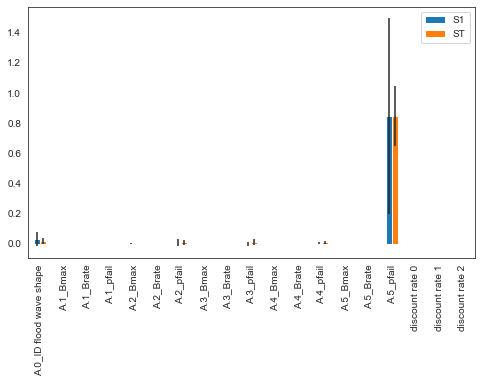

RfR Total Costs
                          ST  ST_conf   S1  S1_conf
A.0_ID flood wave shape  0.0      0.0  0.0      0.0
A.1_Bmax                 0.0      0.0  0.0      0.0
A.1_Brate                0.0      0.0  0.0      0.0
A.1_pfail                0.0      0.0  0.0      0.0
A.2_Bmax                 0.0      0.0  0.0      0.0
A.2_Brate                0.0      0.0  0.0      0.0
A.2_pfail                0.0      0.0  0.0      0.0
A.3_Bmax                 0.0      0.0  0.0      0.0
A.3_Brate                0.0      0.0  0.0      0.0
A.3_pfail                0.0      0.0  0.0      0.0
A.4_Bmax                 0.0      0.0  0.0      0.0
A.4_Brate                0.0      0.0  0.0      0.0
A.4_pfail                0.0      0.0  0.0      0.0
A.5_Bmax                 0.0      0.0  0.0      0.0
A.5_Brate                0.0      0.0  0.0      0.0
A.5_pfail                0.0      0.0  0.0      0.0
discount rate 0          0.0      0.0  0.0      0.0
discount rate 1          0.0      0.0  0.0      

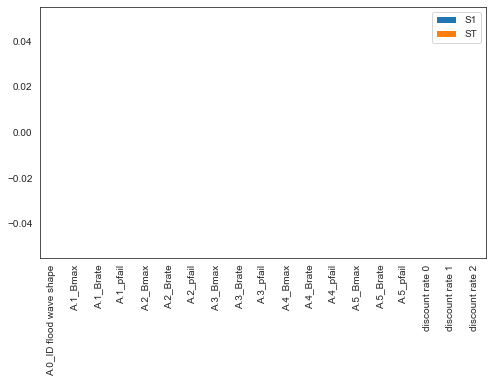

Expected Evacuation Costs
                                   ST       ST_conf            S1  \
A.0_ID flood wave shape  2.261895e-03  1.993343e-03 -1.142187e-03   
A.1_Bmax                 1.245386e-05  2.180441e-05 -7.643697e-04   
A.1_Brate                2.007646e-10  4.149678e-10  7.839502e-07   
A.1_pfail                3.646647e-01  2.492897e-01  3.490537e-01   
A.2_Bmax                 3.038804e-05  4.707216e-05  1.763166e-04   
A.2_Brate                4.883293e-08  6.786869e-08  4.433253e-06   
A.2_pfail                2.046095e-02  2.416741e-02  2.459617e-02   
A.3_Bmax                 5.166448e-10  1.281994e-09 -7.932838e-07   
A.3_Brate                3.638086e-11  8.575037e-11 -2.320754e-07   
A.3_pfail                4.722915e-01  3.292615e-01  3.731503e-01   
A.4_Bmax                 0.000000e+00  0.000000e+00  0.000000e+00   
A.4_Brate                0.000000e+00  0.000000e+00  0.000000e+00   
A.4_pfail                5.627802e-05  7.998106e-05  2.301750e-04   
A.5_Bmax

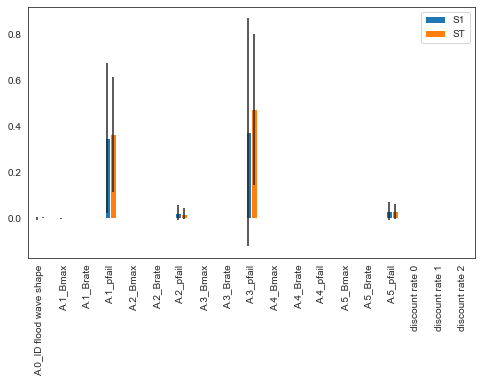

In [13]:
#making a list of the outcome names
outcome_options = ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']

problem = get_SALib_problem(dike_model.uncertainties)

#making a sobol table and sobol figure that shows how much the variable contributes to the variance on its own (first order effects = S1) and contributes when including interactions with other inputs (total effects = ST)
for option in outcome_options:
    outcome_sobol = np.squeeze(outcomes_sobol[option])
    Si = sobol.analyze(problem, outcome_sobol, calc_second_order=True, print_to_console=False)
    Si_filter = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
    Si_df = pd.DataFrame(Si_filter, index=problem["names"])
    print(option)
    print(Si_df)
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()


In [14]:
#MORDM - Many objectives robust decision making
#All the outcomes need to be minimized in the ideal situation, because all types of costs and all deaths should be as low as possible
dike_model.outcomes = [ScalarOutcome('A.1 Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.1_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.2 Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.2_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.3 Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4 Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.5 Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.5_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('Expected Evacuation Costs', kind=ScalarOutcome.MINIMIZE),
                       ]

In [14]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(epsilons=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], nfe=100)

In [ ]:
#defining specific policies
#for example, policy 1 is about extra protection in upper boundary
#policy 2 is about extra protection in lower boundary
#policy 3 is extra protection in random locations
from ema_workbench import Policy

policies = [Policy('policy 1', **{'0_RfR 0':1,
                                  '0_RfR 1':1,
                                  '0_RfR 2':1,
                                  'A.1_DikeIncrease 0':5}),
           Policy('policy 2', **{'4_RfR 0':1,
                                  '4_RfR 1':1,
                                  '4_RfR 2':1,
                                  'A.5_DikeIncrease 0':5}),
           Policy('policy 3', **{'1_RfR 0':1,
                                  '2_RfR 1':1,
                                  '3_RfR 2':1,
                                  'A.3_DikeIncrease 0':5})]

In [ ]:
#pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies)